In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import os
import pickle
import scipy.io as spio
import scipy.stats as sp
import mat73
import seaborn as sns
from scipy.special import factorial
from scipy.special import logsumexp
import pandas as pd
from replay_structure.utils import get_marginal_sum

In [2]:
from replay_structure.structure_trajectory import Most_Likely_Trajectories
import replay_structure.structure_models as models

In [3]:
import replay_structure.structure_models_gridsearch as gridsearch
from replay_structure.config import (
    Structure_Model_Gridsearch_Parameters)
from replay_structure.model_comparison import (
    Gridsearch_Marginalization,
    Model_Comparison,
)

In [4]:
%load_ext autoreload
%autoreload 2

## load data

In [5]:
bin_size_cm=5
#time_window_ms=3
time_window_ms=15

In [6]:
RESULTS_PATH = "/home/katharina/Documents/Studium/MIT/project/1D/results"
filename = RESULTS_PATH+'/structure_analysis_input/Data4Pset_ripples_'+str(bin_size_cm)+'cm_'+str(time_window_ms)+'ms_poisson.obj'
filename_run = RESULTS_PATH+'/structure_analysis_input/Data4Pset_fullrun_'+str(bin_size_cm)+'cm_200ms_poisson.obj'
filename_run_raw = RESULTS_PATH+'/Data4Pset_full_run_'+str(bin_size_cm)+'cm_200ms_poisson.obj'

In [7]:
with open(filename, "rb") as file_object:
    raw_data = file_object.read()
    structure_data = pickle.loads(raw_data)

In [8]:
with open(filename_run, "rb") as file_object:
    raw_data = file_object.read()
    structure_data_run = pickle.loads(raw_data)

In [9]:
with open(filename_run_raw, "rb") as file_object:
    raw_data = file_object.read()
    data_run_raw = pickle.loads(raw_data)

In [15]:
# diffusion grid search results
dif_sd_meters = np.array([1.31, 0.56, 2.32, 0.85, 0.27, 0.64, 0.1 , 0.31, 1.14, 2.32, 3.09,
       0.1 , 2.68, 3.09, 2.32, 0.1 , 0.1 , 0.1 , 0.1 , 4.11, 4.74, 4.11,
       2.32, 2.68, 2.32, 0.85, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.74, 0.1 ,
       0.48, 2.32, 2.01, 1.14, 0.1 , 0.85, 1.74, 2.32, 0.1 , 4.74, 4.11,
       0.1 , 0.1 , 1.31, 1.51, 2.32, 0.1 , 0.98, 0.24, 6.31, 2.68, 0.1 ,
       1.31, 0.1 , 1.31, 0.56, 5.47, 0.48, 3.09, 0.98, 0.1 , 3.56, 0.1 ,
       0.56, 1.74, 2.01, 0.1 , 0.98, 2.32, 0.56, 0.2 , 0.42, 0.85, 0.1 ,
       1.14, 1.14, 0.1 , 6.31, 2.01, 0.98, 6.31, 4.74, 0.64, 0.36, 1.31,
       1.74, 0.1 , 3.56, 0.1 , 0.1 , 0.1 , 0.1 , 0.85, 1.31, 1.51, 1.74,
       1.51, 0.74, 3.09, 0.1 , 1.51, 0.98, 0.1 , 1.74, 0.1 , 3.56, 1.31,
       0.1 , 1.74, 0.1 , 0.1 , 0.64, 1.51, 1.74, 0.24, 2.01, 0.48, 1.51,
       0.1 , 0.1 , 0.85, 0.1 , 0.2 , 0.56, 6.31, 0.56, 0.98, 6.31, 2.32,
       6.31, 0.1 , 0.24, 2.68, 1.31, 0.48, 1.74, 1.14, 0.1 , 0.56, 1.14,
       0.1 , 0.1 , 1.31, 1.74, 3.09, 0.1 , 0.98, 6.31, 0.42, 2.01, 0.1 ,
       3.56, 2.68, 1.74, 3.56, 0.1 , 0.1 , 0.1 , 0.15, 0.1 , 0.1 , 0.1 ,
       0.1 , 0.1 , 6.31, 2.01, 1.31, 0.74, 0.98, 0.1 , 0.74, 2.32, 6.31,
       0.1 , 0.98, 1.51, 0.1 , 1.74, 0.31, 0.98, 0.1 , 0.1 , 1.74, 0.1 ,
       3.56, 0.1 , 1.51, 6.31, 0.36, 0.18, 3.56, 0.56, 0.85, 1.74, 1.74,
       0.1 , 0.1 , 0.42, 0.1 , 0.74, 1.74, 1.51, 1.14, 0.42, 3.56, 0.42,
       1.31, 0.1 , 1.31, 0.1 , 1.51, 1.14, 1.31, 2.01, 1.51, 0.85, 0.1 ,
       1.14, 2.32, 0.1 , 2.32, 0.56, 2.32, 0.1 , 0.48, 0.1 , 0.1 , 1.14,
       0.1 , 0.1 , 0.1 , 0.56, 0.24, 3.56, 0.1 , 0.1 , 2.01, 2.01, 1.14,
       1.74, 0.15, 1.74, 3.09, 0.56, 0.1 , 1.14, 2.01, 1.51, 6.31, 1.51,
       0.31, 6.31, 2.32, 0.1 , 0.1 , 0.48, 0.1 , 0.64, 0.1 , 0.1 , 0.1 ,
       0.74, 0.1 , 3.09, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.56, 0.1 ,
       2.01, 0.1 , 1.14, 0.1 , 0.31, 0.36, 0.42, 0.1 , 1.51, 0.1 , 0.2 ,
       0.36, 4.74, 6.31, 0.1 , 6.31, 1.14, 6.31, 0.1 ])

## get trajectories

In [64]:
index = 277

In [65]:
sd_meters = dif_sd_meters[index-2]

In [66]:
trajectory_results = Most_Likely_Trajectories(structure_data, sd_meters)

Getting most likely trajectories
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
2

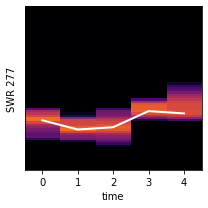

In [67]:
# marginal = models.Momentum(structure_data, 1, 90, 80, plotting=True).get_spikemat_marginals(index)
marginal = models.Diffusion(structure_data, sd_meters).get_spikemat_marginals(index)

marginal_plot = get_marginal_sum(marginal)

plt.figure(figsize=(3,3))
plt.imshow(marginal_plot,aspect='auto', origin='lower', cmap='inferno',vmin=np.log(.001), vmax=np.log(4),interpolation='none')
plt.plot(trajectory_results.most_likely_trajectories[index], c="white", lw="2")
plt.yticks([])
plt.xlabel('time')
plt.ylabel('SWR '+str(index))

plt.tight_layout()
plt.savefig('fig/traj277', dpi=500, transparent=True)

# run

In [15]:
spikemat_ind = 12

In [16]:
params = Structure_Model_Gridsearch_Parameters.run_diffusion_params()
# np.logspace(-1.8, 0, 30))
diffusion_gridsearch = gridsearch.Diffusion(structure_data_run, params)
dif_marginalized_gridsearch = Gridsearch_Marginalization(diffusion_gridsearch)
dif_sd_meters_run = dif_marginalized_gridsearch.marginalization_info["best_fit_gridsearch_params"]["sd_meters"]

sd = 0.016
[-2835.09761588 -4517.1231161  -8265.72906406 -4218.56395024
 -3061.2361368 ]
sd = 0.018
[-2821.31211181 -4269.01567137 -7798.24575917 -3935.26101692
 -2807.48972487]
sd = 0.021
[-2793.42379115 -4048.32575394 -7413.53411197 -3703.79486676
 -2613.55696982]
sd = 0.024
[-2772.4639321  -3758.64417379 -7086.58367116 -3507.58904495
 -2456.54078304]
sd = 0.028
[-2550.65056074 -3511.51917592 -6814.88722315 -3355.20470726
 -2323.42005372]
sd = 0.032
[-2344.68578929 -3310.60525089 -6593.67490044 -3236.98362416
 -2217.15441676]
sd = 0.037
[-2183.76906568 -3150.49478799 -6413.20360399 -3144.03203764
 -2133.85233269]
sd = 0.043
[-2061.92779872 -3029.70224    -6272.29425748 -3068.80539863
 -2068.02708382]
sd = 0.05
[-1970.80635792 -2940.25993073 -6166.39059106 -3005.21593994
 -2017.47845932]
sd = 0.057
[-1903.06448675 -2874.41430643 -6086.65109176 -2956.32302944
 -1980.22427801]
sd = 0.066
[-1852.70408439 -2825.79597023 -6024.63260818 -2919.24741275
 -1953.02218125]
sd = 0.076
[-1815.0223

/home/katharina/anaconda3/envs/test_enviornment1/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/katharina/Documents/Studium/MIT/project/1D/replay_structure/model_comparison.py:233: RuntimeWarning: divide by zero encountered in log
  self.gridsearch_results + np.log(sd_prior_normalized), axis=1


(array([8., 1., 2., 0., 1., 0., 0., 0., 0., 1.]),
 array([0.1559924 , 0.21553158, 0.27507077, 0.33460995, 0.39414913,
        0.45368831, 0.51322749, 0.57276667, 0.63230586, 0.69184504,
        0.75138422]),
 <BarContainer object of 10 artists>)

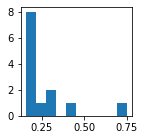

In [17]:
plt.figure(figsize=(2,2))
plt.hist(dif_sd_meters_run)

In [18]:
sd_meters_run = dif_sd_meters_run[spikemat_ind]
trajectory_results_run = Most_Likely_Trajectories(structure_data_run, sd_meters_run)

Getting most likely trajectories
0
1
2
3
4
5
6
7
8
9
10
11
12


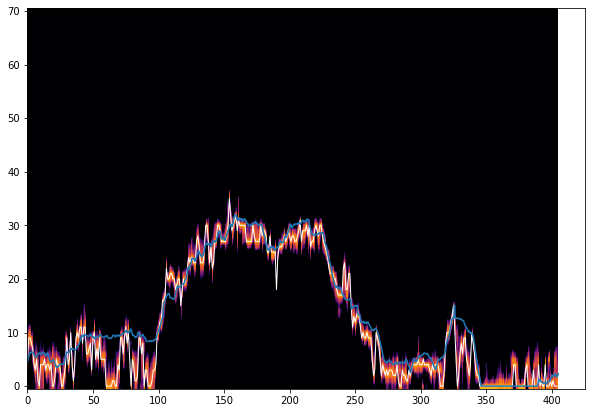

In [24]:
marginal = models.Diffusion(structure_data_run, sd_meters_run).get_spikemat_marginals(spikemat_ind)
marginal_plot = get_marginal_sum(marginal)
plt.figure(figsize=(10,7))
plt.imshow(marginal_plot,
           aspect='auto', origin='lower', cmap='inferno',vmin=np.log(.001), vmax=np.log(4))
plt.plot(trajectory_results_run.most_likely_trajectories[spikemat_ind], c="white", lw="1")
t = np.linspace(0 , marginal.shape[1], data_run_raw.run_info['true_trajectories_cm'][spikemat_ind].shape[0])
plt.plot(t, data_run_raw.run_info['true_trajectories_cm'][spikemat_ind]/5)